In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models, losses, optimizers, backend
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D  # just to enable 3D plotting

import warnings
warnings.filterwarnings('ignore')

In [2]:
%run C:\Users\mvana\Documents\Python\ML\000_ML_Functions.ipynb

In [3]:
# Load data
df = pd.read_csv(r"C:\Users\mvana\Documents\MSc\Temp_O3_H2O\Data\saber_agg.csv")
df['year_month'] = pd.to_datetime(df['year_month']).dt.to_period('M')
df = df.sort_values(['altitude_bin', 'year_month'])
df = df[(df['altitude_bin'] >= 50) & (df['altitude_bin'] <= 109)]

In [4]:
lookback = 24
forecast = 24

# Remove the first `lookback` rows for each altitude_bin group
df_sliced = df.groupby('altitude_bin').apply(lambda g: g.iloc[lookback:]).reset_index(drop=True)
df_sliced = df_sliced.groupby('altitude_bin').apply(lambda g: g.iloc[:- forecast]).reset_index(drop=True)
features = ['altitude_bin', 'year', 'month', 'num_season', 'year_season']
# Ensure correct sort order
df_sliced = df_sliced.sort_values(['year', 'month'] + ['altitude_bin'])
# Get unique altitudes
altitudes = sorted(df_sliced['altitude_bin'].unique())
# For each altitude, extract feature values over time
X_1_list = []
for alt in altitudes:
    subset = df_sliced[df_sliced['altitude_bin'] == alt]
    X_alt = subset[features].to_numpy().T  # Transpose so shape becomes (5, time)
    X_1_list.append(X_alt)

# Now stack along new axis → (5, time, alt) → then transpose
X_1 = np.stack(X_1_list, axis=-1)  # shape: (5, time, alt)
X_1 = X_1.transpose(1, 0, 2)       # shape: (time, 5, alt)
X_1, X_1_scaler, _, _ = scale_array(X_1)

In [5]:
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+pred_len])
    return np.array(X), np.array(y)

In [6]:
# Pivot: each column is an altitude, each row is a time step
df_pivot = df.pivot(index='year_month', columns='altitude_bin', values='ktemp')
df_pivot = df_pivot.interpolate().dropna(axis=1)  # fill missing

In [7]:
X_2, y = create_sequences(df_pivot, lookback, forecast)

# Normalize data
X_2, X_2_scaler, y, y_scaler = scale_array(X_2, y)

In [8]:
# Define sizes
train_size = int(len(X_2) * 0.7)
val_size = int(len(X_2) * 0.15)

# Split into train, validation, and test
X_1_train, X_2_train, y_train = X_1[:train_size], X_2[:train_size], y[:train_size]
X_1_val, X_2_val, y_val     = X_1[train_size:train_size + val_size], X_2[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_1_test, X_2_test, y_test   = X_1[train_size + val_size:], X_2[train_size + val_size:], y[train_size + val_size:]

In [9]:
# LSTM Model
def build_model(hp):

    inputs1 = layers.Input(shape=(X_1.shape[1],X_1.shape[2], 1), name='static_input')
    x1 = layers.Conv2D(32, (2, 3), activation='relu')(inputs1)
    x1 = layers.MaxPooling2D((1, 2))(x1)
    x1 = layers.Flatten()(x1)
    x1 = layers.Dense(64, activation='relu')(x1)
    
    inputs2= layers.Input(shape=(X_2.shape[1], X_2.shape[2]), name='sequence_input')
    x2 = layers.LSTM(64, return_sequences=True, activation='relu')(inputs2)
    x2 = layers.LSTM(64, return_sequences=True, activation='relu')(x2)
    x2 = layers.LSTM(64, return_sequences=True, activation='relu')(x2)
    x2 = layers.LSTM(64, return_sequences=False, activation='relu')(x2)

    # Concatenate both branches
    combined = layers.Concatenate()([x1, x2])
    # Shared dense layer
    z = layers.Dense(y_train.shape[1] * y_train.shape[2], activation='relu')(combined)
    outputs = layers.Reshape((y_train.shape[1], y_train.shape[2]))(z)

    model = models.Model(inputs=[inputs1, inputs2], outputs=outputs)

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_beta_1 = hp.Float('beta_1', min_value=0.8, max_value=0.99, step=0.01, default=0.9)
    hp_beta_2 = hp.Float('beta_2', min_value=0.9, max_value=0.999, step=0.001, default=0.999)
    hp_epsilon = hp.Float('epsilon', min_value=1e-8, max_value=1e-6, sampling='LOG', default=1e-7)
    hp_amsgrad = hp.Boolean('amsgrad', default=False)
    hp_weight_decay = hp.Float('weight_decay', min_value=1e-6, max_value=1e-2, sampling='LOG', default=1e-4)

    # Use AdamW (supports weight decay)
    optimizer = optimizers.AdamW(learning_rate=hp_learning_rate, beta_1=hp_beta_1, 
                                 beta_2=hp_beta_2, epsilon=hp_epsilon, amsgrad=hp_amsgrad,
                                 weight_decay=hp_weight_decay)
    
    model.compile(optimizer=optimizer, loss='mse', metrics = ['mae', rmse, mae_profile, r2_keras, explained_variance_keras, pearson_correlation])
    return model

# model = build_model(hp)

In [10]:
tuner = kt.Hyperband(
    build_model,
    objective='val_mae',  # or 'val_loss'
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='time_series_2D'
)

Reloading Tuner from my_dir\time_series_2D\tuner0.json


In [11]:
tuner.search([X_1_train, X_2_train], y_train, epochs=100, validation_data=([X_1_val, X_2_val], y_val))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [12]:
print("Best hyperparameters found:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

Best hyperparameters found:
learning_rate: 0.001
beta_1: 0.8200000000000001
beta_2: 0.998
epsilon: 2.9530889796870456e-07
amsgrad: True
weight_decay: 0.00011824014373138818
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012


In [13]:
model = tuner.hypermodel.build(best_hps)
history = model.fit([X_1_train, X_2_train], y_train, epochs=500, verbose=0, validation_data=([X_1_val, X_2_val], y_val))

In [14]:
def evaluate_forecast(y_true, y_pred):
    # Overall
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

    # Per altitude
    mae_per_alt = np.mean(np.abs(y_pred - y_true), axis=(0,1))
    rmse_per_alt = np.sqrt(np.mean((y_pred - y_true)**2, axis=(0,1)))

    # Per lead time
    mae_per_time = np.mean(np.abs(y_pred - y_true), axis=(0,2))
    rmse_per_time = np.sqrt(np.mean((y_pred - y_true)**2, axis=(0,2)))

    return {
        "mae": mae,
        "rmse": rmse,
        "mae_per_altitude": mae_per_alt,
        "rmse_per_altitude": rmse_per_alt,
        "mae_per_time": mae_per_time,
        "rmse_per_time": rmse_per_time
    }

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 659ms/step


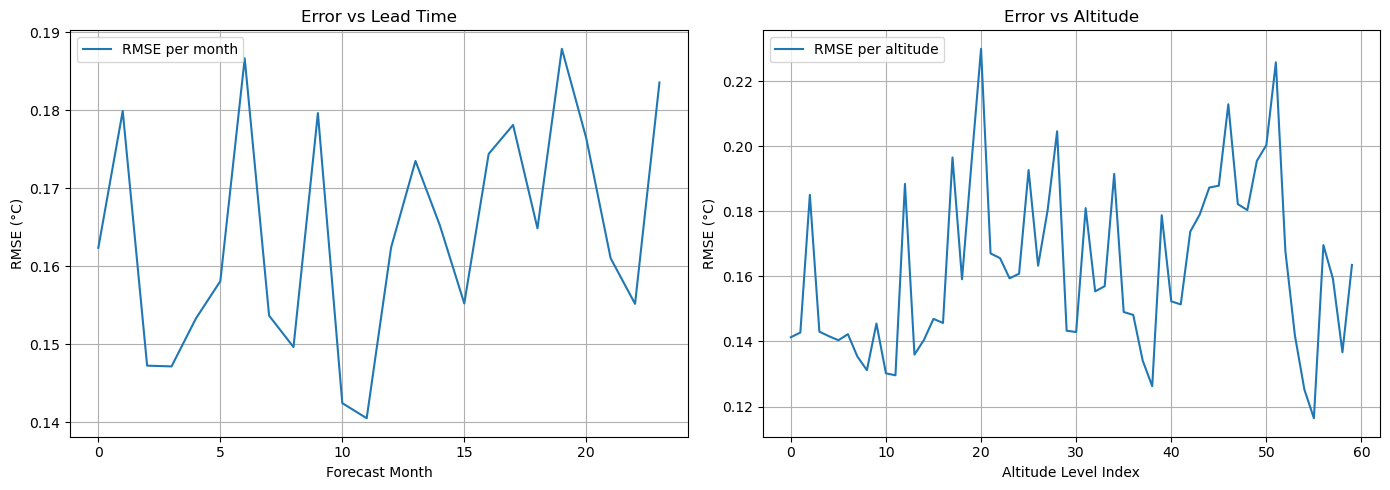

In [15]:
# y_true, y_pred = arrays with shape (samples, time, altitude)
metrics = evaluate_forecast(y_test, model.predict([X_1_test, X_2_test]))

plt.figure(figsize=(14, 5))

# Per forecast month
plt.subplot(1, 2, 1)
plt.plot(metrics["rmse_per_time"], label='RMSE per month')
plt.xlabel('Forecast Month')
plt.ylabel('RMSE (°C)')
plt.title('Error vs Lead Time')
plt.grid(True)
plt.legend()

# Per altitude
plt.subplot(1, 2, 2)
plt.plot(metrics["rmse_per_altitude"], label='RMSE per altitude')
plt.xlabel('Altitude Level Index')
plt.ylabel('RMSE (°C)')
plt.title('Error vs Altitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

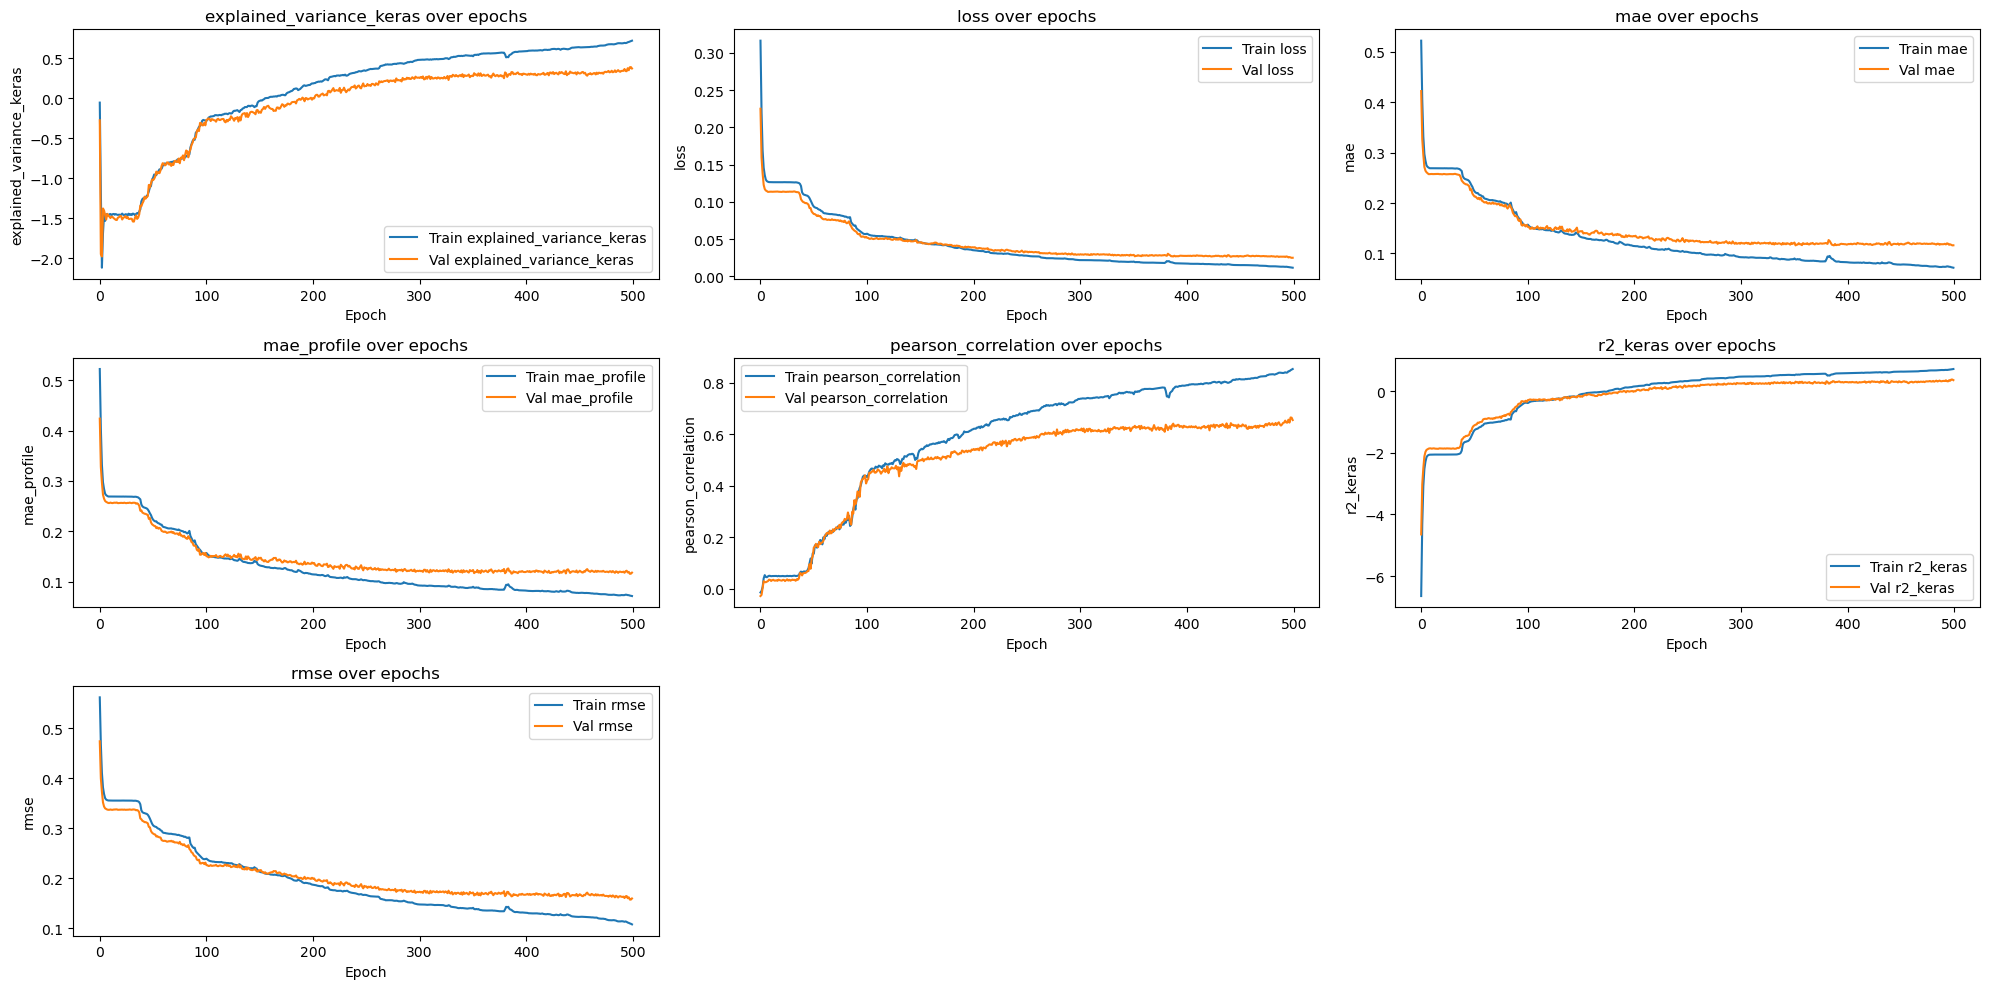

In [51]:
metrics = [m for m in history.history.keys() if not m.startswith('val_')]
rows = len(metrics)//2
cols = len(metrics)//2

plt.figure(figsize=(20, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(rows, cols, i)
    plt.plot(history.history[metric], label=f'Train {metric}')
    val_metric = f'val_{metric}'
    if val_metric in history.history:
        plt.plot(history.history[val_metric], label=f'Val {metric}')
    plt.title(f'{metric} over epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

In [29]:
y_pred_scaled = model.predict([X_1_test, X_2_test])

# Flatten and reshape if needed (depends on your scaler implementation)
n_samples = y_pred_scaled.shape[0]
n_timesteps = y_pred_scaled.shape[1]
n_features = y_pred_scaled.shape[2]

y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)
y_true = y_scaler.inverse_transform(y_test.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [43]:
sample_idx

1

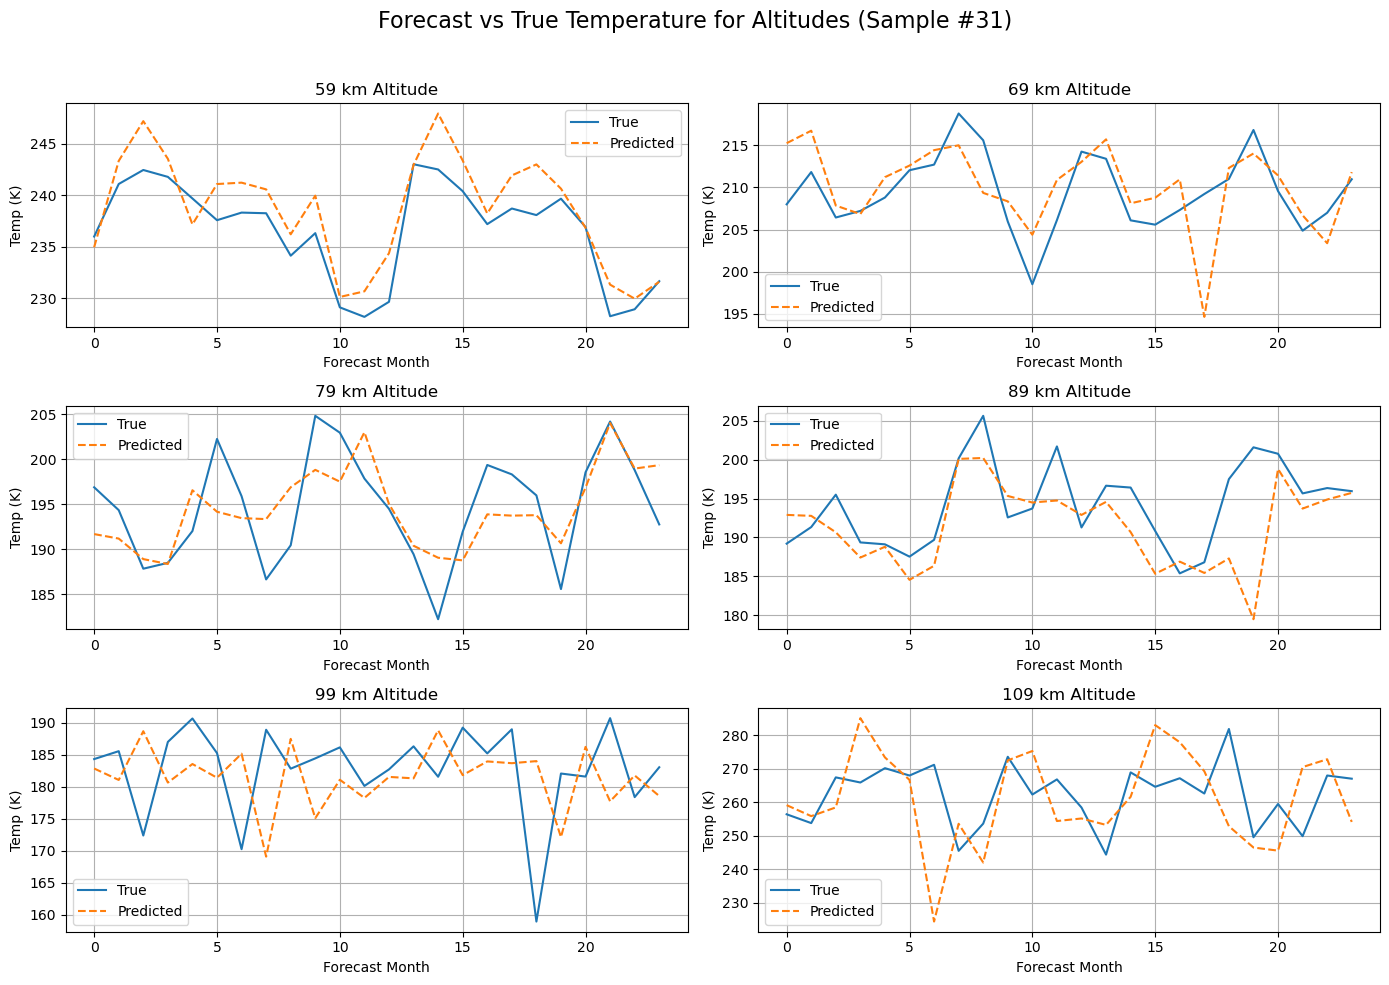

In [52]:
# Define the target altitudes
altitude_options = [59, 69, 79, 89, 99, 109]

# Get their indices in the df_pivot.columns
alt_indices = [list(df_pivot.columns).index(alt) for alt in altitude_options]

# Randomly select a sample index from test set
sample_idx = np.random.randint(len(y_test))

# Plot in 3x2 subplots
plt.figure(figsize=(14, 10))
for plot_idx, (alt, idx) in enumerate(zip(altitude_options, alt_indices), start=1):
    plt.subplot(3, 2, plot_idx)
    plt.plot(y_true[sample_idx, :, idx], label='True')
    plt.plot(y_pred[sample_idx, :, idx], linestyle='--', label='Predicted')
    plt.title(f"{alt} km Altitude")
    plt.xlabel("Forecast Month")
    plt.ylabel("Temp (K)")
    plt.grid(True)
    plt.legend()

plt.suptitle(f"Forecast vs True Temperature for Altitudes (Sample #{sample_idx})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
# Save figure
plt.savefig(r"C:\Users\mvana\Documents\MSc\Temp_O3_H2O\Plots\publish\forecast_vs_true_altitudes.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
df_pivot_test_window = df_pivot.iloc[train_size + val_size:]

In [35]:
X_test_unscaled, y_test_unscaled= inverse_scale_array(X_2_test, y_test, X_2_scaler, y_scaler)

pivot_true = reverse_sequences_with_overlap(X_test_unscaled, y_test_unscaled, lookback, forecast)

pivot_true = pd.DataFrame(pivot_true)
pivot_true.index = df_pivot_test_window.index
pivot_true.columns = df_pivot_test_window.columns
pivot_true = pivot_true[pivot_true.index != pd.Period('2024-12', freq='M')]

In [36]:
y_pred, _ = inverse_scale_array(y_pred_scaled, scaler1=y_scaler)

pivot_pred = reverse_sequences_with_overlap(X_test_unscaled, y_pred, lookback, forecast)

pivot_pred = pd.DataFrame(pivot_pred)
pivot_pred.index = df_pivot_test_window.index
pivot_pred.columns = df_pivot_test_window.columns
pivot_pred = pivot_pred[pivot_pred.index != pd.Period('2024-12', freq='M')]

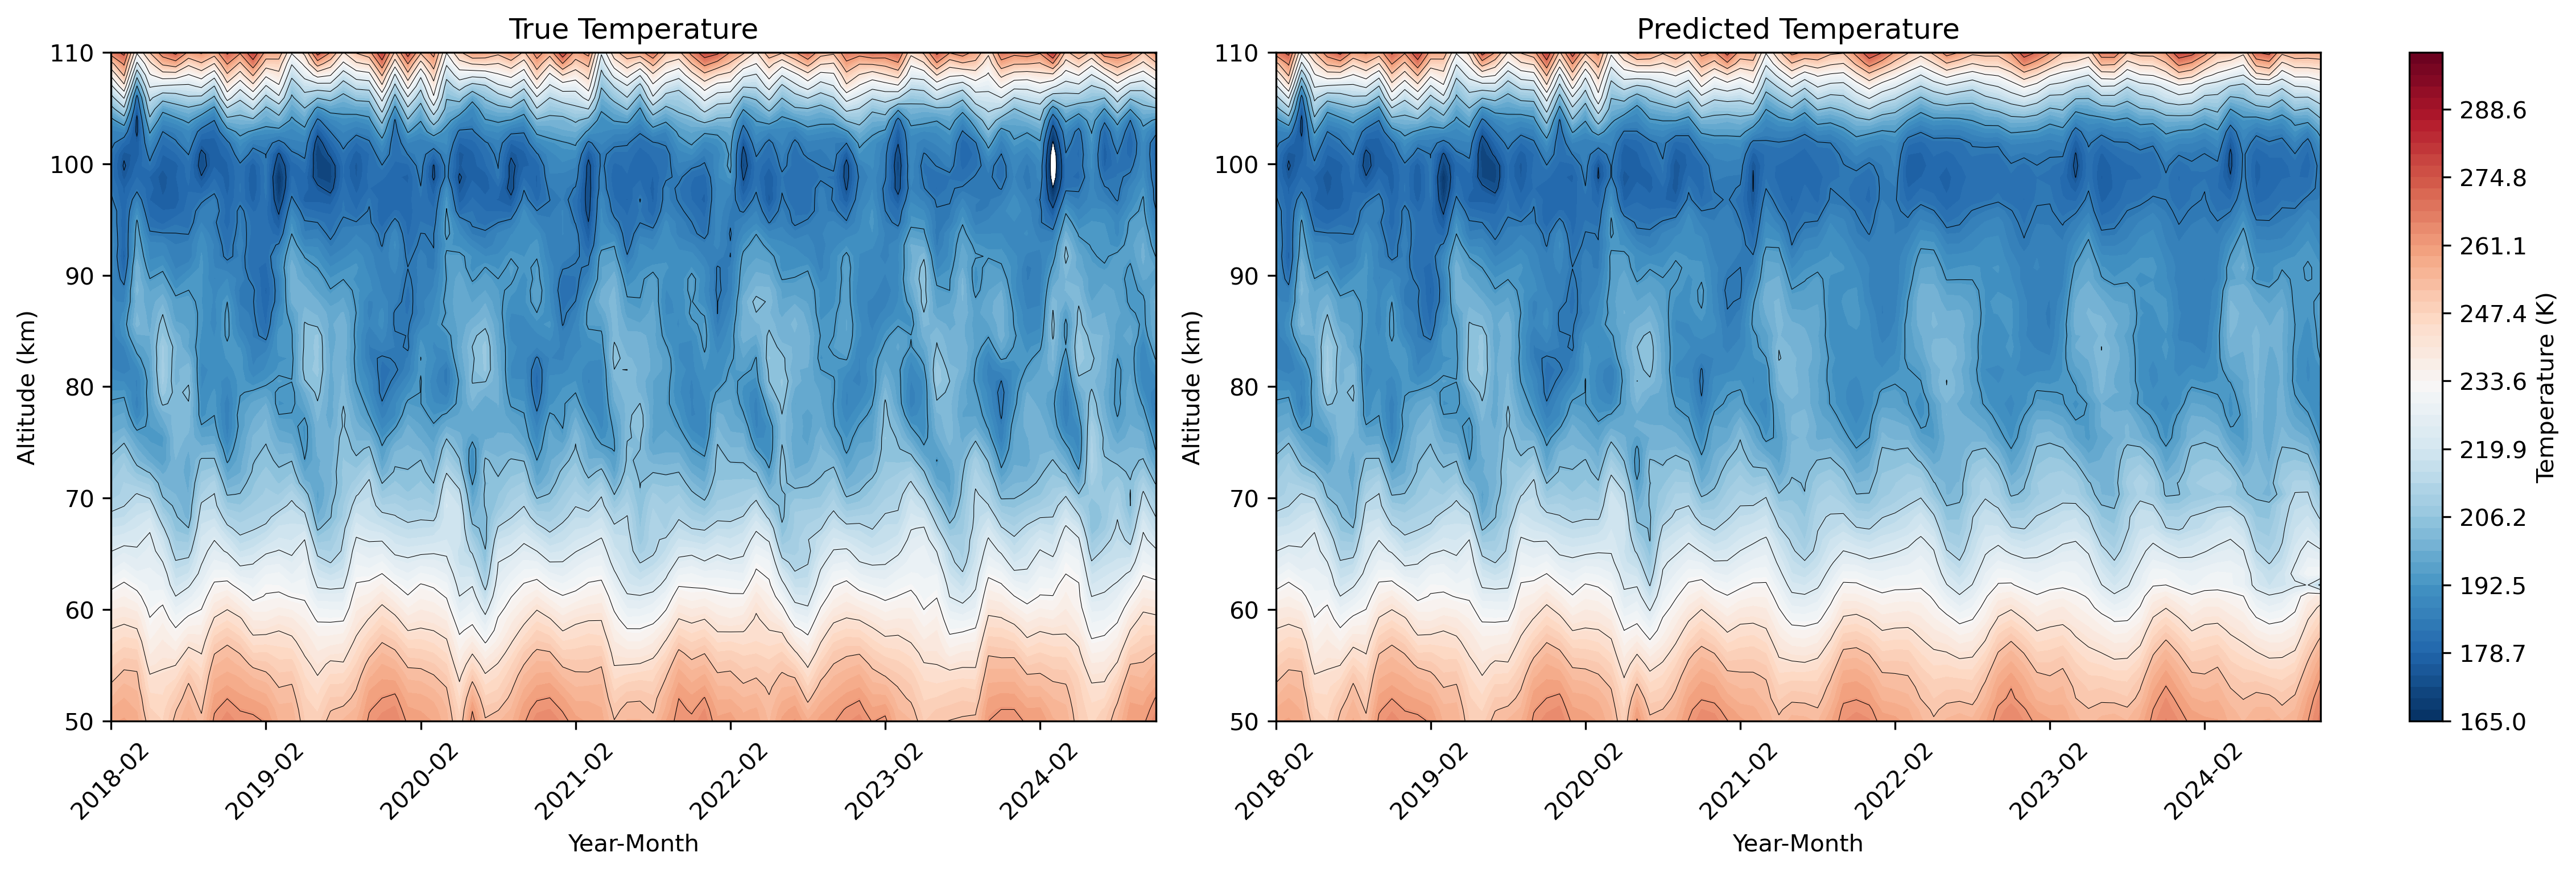

In [53]:
norm = Normalize(vmin=165, vmax=300)  # Common normalization for both
levels = np.linspace(165, 300, 60)
line_levels = np.linspace(165, 300, 15)

fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=300, constrained_layout=True)

# Extract time (x-axis) and altitude (y-axis)
time_index = pivot_true.index        # PeriodIndex
altitudes = np.linspace(50, 110, pivot_true.shape[1])  # adjust as needed

for ax, data, title in zip(
    axs,
    [pivot_true.values, pivot_pred.values],
    ['True Temperature', 'Predicted Temperature']
):
    # Meshgrid with real axis values
    Y, X = np.meshgrid(altitudes, np.arange(len(time_index)))
    
    cf = ax.contourf(X, Y, data, cmap='RdBu_r', norm=norm, levels=levels)
    contours = ax.contour(X, Y, data, levels=line_levels, colors='black', linewidths=0.25)

    # Y-axis (Altitude)
    ax.set_yticks([50, 60, 70, 80, 90, 100, 110])

    # X-axis (Year-Month)
    ax.set_xticks(np.arange(0, len(time_index), 12))  # yearly ticks
    ax.set_xticklabels([t.strftime('%Y-%m') for t in time_index[::12]], rotation=45)

    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Altitude (km)')
    ax.set_title(title)

# Add a single colorbar
cbar = fig.colorbar(cf, ax=axs, orientation='vertical', fraction=0.025, pad=0.04)
cbar.set_label('Temperature (K)')
# Save animation
plt.savefig(r"C:\Users\mvana\Documents\MSc\Temp_O3_H2O\Plots\publish\Temperature Time-Height Heatmap-Prediction.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:

norm = Normalize(vmin=165, vmax=300)

# Prepare grids
X, Y = np.meshgrid(np.arange(pivot_true.shape[1]), np.arange(pivot_true.shape[0]))

fig = plt.figure(figsize=(16, 7), dpi=150)
axes = []

# Extract time (x-axis) and altitude (y-axis)
time_index = pivot_true.index        # PeriodIndex
altitudes = np.linspace(50, 110, pivot_true.shape[1])  # adjust as needed


for i, (data, title) in enumerate(zip(
    [pivot_true.values, pivot_pred.values],
    ['True Temperature', 'Predicted Temperature']
), start=1):
    
    ax = fig.add_subplot(1, 2, i, projection='3d')
    
    ax.plot_surface(
        X, Y, data,
        cmap='RdBu_r',
        norm=norm,
        edgecolor='none',
        alpha=0.9
    )

    # Y-axis (Altitude)
    ax.set_yticks([50, 60, 70, 80, 90, 100, 110])

    # X-axis (Year-Month)
    ax.set_xticks(np.arange(0, len(time_index), 12))  # yearly ticks
    ax.set_xticklabels([t.strftime('%Y-%m') for t in time_index[::12]], rotation=45)
    
    # X axis labels
    ax.set_ylabel('Year-Month')
    ax.set_xlabel('Altitude (km)')

    ax.set_zlabel('Temperature (K)')
    ax.set_title(title)

    axes.append(ax)

# Shared colorbar
mappable = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
mappable.set_array(np.concatenate([pivot_true.values.flatten(), pivot_pred.values.flatten()]))
cbar = fig.colorbar(mappable, ax=fig.get_axes(), orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label('Temperature (K)')

# Animation parameters
fps = 40
frames = fps * 30

# Elevation path: 90 → -10 → 90
elev_down = np.linspace(90, -10, frames // 2)
elev_up = np.linspace(-10, 90, frames // 2)
elev_values = np.concatenate([elev_down, elev_up])

# Azimuth path: 180 → 180 + 720 + 720
azim_values = np.linspace(180, 180 + 1440, frames)

def animate(frame):
    elev = elev_values[frame]
    azim = azim_values[frame]
    for ax in axes:
        ax.view_init(elev=elev, azim=azim)

ani = FuncAnimation(fig, animate, frames=frames, interval=1000/fps)

ani.save("temperature_spiral_10.gif", writer=PillowWriter(fps=fps))
plt.close(fig)
print("GIF saved as temperature_spiral.gif")

GIF saved as temperature_spiral.gif
